In [2]:
# data exploration and visualization
import pandas as pd
import numpy as np
import json 
import re 
import joblib 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime 
import os 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [5]:
# load and combine data
data_dir = Path("C:/DATASCI/air-quality-forecast/dataset")
all_files = list(data_dir.glob("*.csv"))

data_list = []
for file in all_files:
    try:
        df = pd.read_csv(file, sep=';')
        if not df.empty:
            data_list.append(df)
    except pd.errors.EmptyDataError:
        print(f"Skipped empty file: {file}")

data = pd.concat(data_list, ignore_index=True)
data.columns = data.columns.str.strip()  # Remove whitespace from column names
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)
print(data.info()) # Display first few rows

Skipped empty file: C:\DATASCI\air-quality-forecast\dataset\May 2025.csv
Skipped empty file: C:\DATASCI\air-quality-forecast\dataset\Sep 2025.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 475322 entries, 2023-11-01 16:44:12.409509+00:00 to NaT
Data columns (total 8 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   sensor_id                                      340818 non-null  float64
 1   sensor_type                                    340818 non-null  object 
 2   location                                       340818 non-null  float64
 3   lat                                            340818 non-null  float64
 4   lon                                            340818 non-null  float64
 5   value_type                                     340818 non-null  object 
 6   value                                          340818 non-null  float64
 7   timestamp,PM1,P

In [6]:
# data exploration
print(data.head())

                                  sensor_id sensor_type  location    lat  \
timestamp                                                                  
2023-11-01 16:44:12.409509+00:00     4856.0       DHT22    3629.0  6.428   
2023-11-01 16:44:12.409509+00:00     4856.0       DHT22    3629.0  6.428   
2023-11-01 16:44:52.764459+00:00     4855.0     pms5003    3629.0  6.428   
2023-11-01 16:44:52.764459+00:00     4855.0     pms5003    3629.0  6.428   
2023-11-01 16:44:52.764459+00:00     4855.0     pms5003    3629.0  6.428   

                                    lon   value_type  value  \
timestamp                                                     
2023-11-01 16:44:12.409509+00:00  3.435     humidity   82.6   
2023-11-01 16:44:12.409509+00:00  3.435  temperature   29.4   
2023-11-01 16:44:52.764459+00:00  3.435           P2   19.0   
2023-11-01 16:44:52.764459+00:00  3.435           P1   25.0   
2023-11-01 16:44:52.764459+00:00  3.435           P0   14.0   

                         

In [7]:
# drop columns sensor_id, location, lat, lon
data.drop(columns=['sensor_id', 'sensor_type', 'location', 'lat', 'lon', 'timestamp,PM1,PM10,PM2.5,humidity,temperature'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 475322 entries, 2023-11-01 16:44:12.409509+00:00 to NaT
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   value_type  340818 non-null  object 
 1   value       340818 non-null  float64
dtypes: float64(1), object(1)
memory usage: 10.9+ MB


In [8]:
# check for missing values
print(data.isnull().sum())

value_type    134504
value         134504
dtype: int64


In [9]:
# unique values
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

value_type: 5 unique values
value: 6036 unique values


In [10]:
# Rename value_type column for clarity
data['value_type'] = data['value_type'].replace({'P0': 'PM1', 'P1': 'PM10', 'P2': 'PM2.5'})
print(data['value_type'].head())

timestamp
2023-11-01 16:44:12.409509+00:00       humidity
2023-11-01 16:44:12.409509+00:00    temperature
2023-11-01 16:44:52.764459+00:00          PM2.5
2023-11-01 16:44:52.764459+00:00           PM10
2023-11-01 16:44:52.764459+00:00            PM1
Name: value_type, dtype: object


In [11]:
# strip whitespace from column names
data.columns = data.columns.str.strip()

In [12]:
# from value_type column, create separate columns for Temperature, Humidity, PM1, PM10, PM2.5
data = pd.DataFrame({
    'value_type': data['value_type'],
    'value': data['value']
    })

data_pivot = data.pivot_table(index=data.index,
                              columns='value_type', 
                              values='value')
print(data_pivot)


value_type                         PM1   PM10  PM2.5  humidity  temperature
timestamp                                                                  
2023-11-01 16:44:12.409509+00:00   NaN    NaN    NaN      82.6         29.4
2023-11-01 16:44:52.764459+00:00  14.0  25.00  19.00       NaN          NaN
2023-11-01 16:45:05.919275+00:00   NaN    NaN    NaN      80.3         29.7
2023-11-01 17:52:08.924982+00:00   2.5   4.25   3.50       NaN          NaN
2023-11-01 17:52:22.386859+00:00   NaN    NaN    NaN      78.0         30.5
...                                ...    ...    ...       ...          ...
2025-08-01 06:02:18.715761+00:00  28.0  44.00  38.50       NaN          NaN
2025-08-01 06:02:29.022006+00:00   NaN    NaN    NaN     100.0         27.3
2025-08-01 06:05:09.156115+00:00  19.0  27.00  26.00       NaN          NaN
2025-08-01 06:05:19.364039+00:00   NaN    NaN    NaN     100.0         27.3
2025-08-01 06:07:59.373993+00:00   NaN  14.00  12.33       NaN          NaN

[134504 row

In [13]:
# fill NaN values with 0
data_pivot_filled = data_pivot.fillna(0)
print('filled with 0:\n', data_pivot_filled)

filled with 0:
 value_type                         PM1   PM10  PM2.5  humidity  temperature
timestamp                                                                  
2023-11-01 16:44:12.409509+00:00   0.0   0.00   0.00      82.6         29.4
2023-11-01 16:44:52.764459+00:00  14.0  25.00  19.00       0.0          0.0
2023-11-01 16:45:05.919275+00:00   0.0   0.00   0.00      80.3         29.7
2023-11-01 17:52:08.924982+00:00   2.5   4.25   3.50       0.0          0.0
2023-11-01 17:52:22.386859+00:00   0.0   0.00   0.00      78.0         30.5
...                                ...    ...    ...       ...          ...
2025-08-01 06:02:18.715761+00:00  28.0  44.00  38.50       0.0          0.0
2025-08-01 06:02:29.022006+00:00   0.0   0.00   0.00     100.0         27.3
2025-08-01 06:05:09.156115+00:00  19.0  27.00  26.00       0.0          0.0
2025-08-01 06:05:19.364039+00:00   0.0   0.00   0.00     100.0         27.3
2025-08-01 06:07:59.373993+00:00   0.0  14.00  12.33       0.0          

In [14]:
# save cleaned data
data_pivot_filled.to_csv(data_dir / "cleaned_air_quality_data.csv")

In [15]:
# describe data
print(data_pivot_filled.describe())

value_type            PM1           PM10          PM2.5       humidity  \
count       134504.000000  134504.000000  134504.000000  134504.000000   
mean            11.976074      21.353260      18.620846      32.777907   
std             16.984301      29.482717      26.044508      37.662255   
min              0.000000       0.000000       0.000000       0.000000   
25%              0.000000       0.000000       0.000000       0.000000   
50%              7.000000      12.500000      11.400000       0.000000   
75%             20.000000      33.830000      30.300000      70.500000   
max            683.500000     693.500000     690.000000     100.000000   

value_type    temperature  
count       134504.000000  
mean            15.277594  
std             17.926817  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%             32.000000  
max            150.000000  


In [16]:
# compute correlation matrix
corr = data_pivot_filled.corr()
corr 

value_type,PM1,PM10,PM2.5,humidity,temperature
value_type,,,,,
PM1,1.000000,0.901093,0.901794,-0.613684,-0.600927
PM10,0.901093,1.000000,0.994987,-0.630340,-0.617237
PM2.5,0.901794,0.994987,1.000000,-0.622245,-0.609310
humidity,-0.613684,-0.630340,-0.622245,1.000000,0.846523
temperature,-0.600927,-0.617237,-0.609310,0.846523,1.000000


<Axes: xlabel='value_type', ylabel='value_type'>

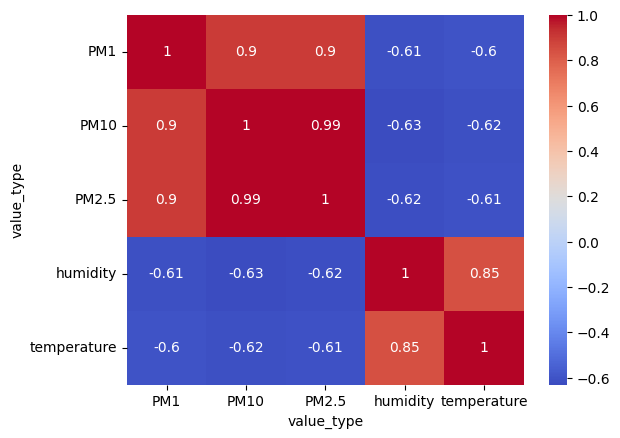

In [17]:
sns.heatmap(corr,annot=True,cbar=True, cmap='coolwarm')

In [18]:
# train-test split
X = data_pivot_filled.drop(columns=['PM2.5'])
y = data_pivot_filled['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
# prediction
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

In [22]:
train_rsme = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Train RMSE: {train_rsme: .2f}")
print(f"Test RMSE: {test_rmse: .2f}")
print(f"Train R2: {test_r2: .4f}")
print(f"Test R2: {test_r2: .4f}")

Train RMSE:  0.98
Test RMSE:  1.71
Train R2:  0.9957
Test R2:  0.9957


In [23]:
# feature importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

       Feature  Importance
1         PM10    0.996944
0          PM1    0.003019
3  temperature    0.000029
2     humidity    0.000008


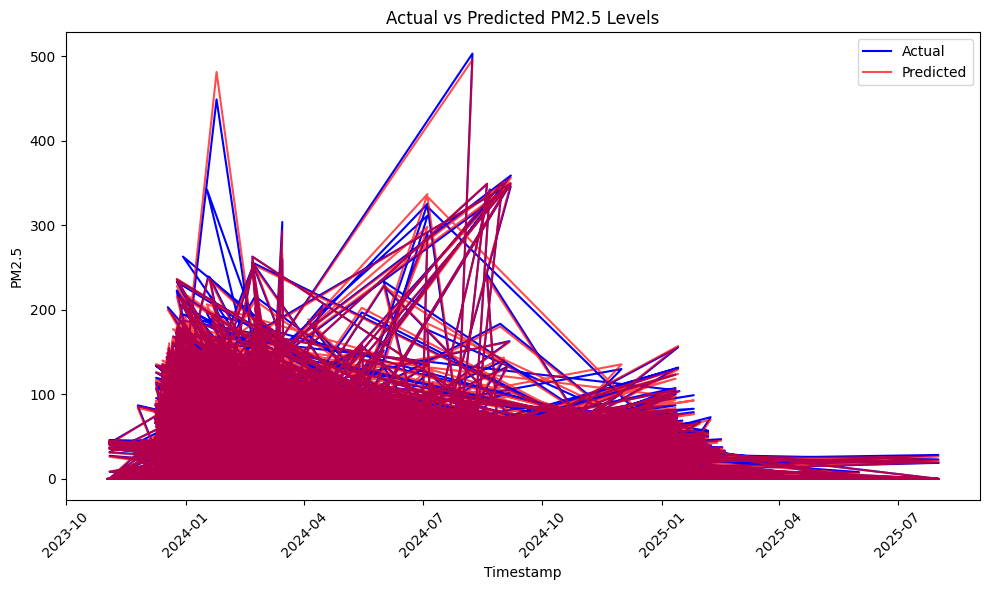

In [25]:
# plot predicted vs actual
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_test, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 Levels')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# save the model
joblib.dump(rf, data_dir / "rf_pm25_model.joblib")
joblib.dump(scaler, data_dir / "scaler_pm25_model.joblib")
print("Model and scaler saved.")

Model and scaler saved.
